In [1]:
using DifferentialEquations
using Distributions
using FFTW
using HypothesisTests
using LinearAlgebra
using LsqFit
using NLsolve
using Random
using SpecialFunctions
using Statistics
using StatsBase
using PyPlot
using Printf
using HDF5
rng = MersenneTwister(1234)

MersenneTwister(1234)

# Single Population

In [2]:
struct PopParams
    n::Int64                        # SSN power
    α::Float64                      # SSN parameter
    γ̄::Float64                      # mean connection parameter
    γ::Float64                      # connection variance parameter
    ḡ::Float64                      # time-independent input
    δg::Float64                     # time-dependent input amplitude
    ω::Float64                      # time-dependent input frequency
    τ::Float64                      # time constant
    PopParams(n::Int64,α::Float64,γ̄::Float64,γ::Float64,ḡ::Float64,δg::Float64,ω::Float64,
        τ::Float64) = new(n,α,γ̄,γ,ḡ,δg,ω,τ)
    PopParams(n::Int64,α::Float64,γ::Float64,δg::Float64,ω::Float64,τ::Float64) =
        new(n,α,-1.0,γ,α^(1/(n-1)),α^(1/(n-1))*δg,ω,τ)
end

In [3]:
#################################################################################
## this script integrates rate networks                                        ##
## Rainer Engelken 2021                                                        ##
#################################################################################

# efficient implementation of chaotic rate network
function rate(N::Int64,pp::PopParams,init::Vector{Float64},Nmeas::Int64,
        Tsim,Twrm,dts,seed,tol)
    Random.seed!(seed)              # seed random number generator
    function φ(h::Float64)::Float64 # rectified power law activation function
        min(max(h,0)^pp.n,(10*(pp.ḡ+pp.δg))^pp.n)
    end
    
    ####################################################################
    #### Gamma Distributed connectivity weights ########################
    ####################################################################
    W = rand(Gamma(pp.γ̄^2/(pp.γ^2*N),pp.γ^2/abs(pp.γ̄)),(N,N))
    W .*= sign(pp.γ̄)                # generate initial network topology
#     W[diagind(W)] .= pp.γ̄/N         # remove variability in autapses
#     W[W .> 0] .= 0.0                # set all connections to be negative
    
    h0 = init[1].+init[2]*randn(N)  # initialize network state
    τinv = 1/pp.τ                   # calculate inverse time constant
    tspan = (0.0,Tsim)              # define time span to simulate
    tsave = Twrm:dts:Tsim           # define times to save network state
    
    ####################################################################
    #### optimized hyperparameters of Tsitouras 5/4 Runge-Kutta method #
    ####################################################################
    beta2 = 0.045
    rtol = 1e-8
    gamma = 0.95
    dt = 0.17
    maxi = 10^7
    
    r = Array{Float64}(undef,N)     # preallocate vector of firing rates
    idxs = [1:Nmeas;]               # indices of neurons to measure
    function f(dh,h,nothing,t)      # function with equation of motion passed to 
                                    # DifferentialEquations
        g = pp.ḡ+pp.δg*sin(pp.ω*t)  # calculate input at this time
        dh .= g.-h                  # use dh vector initially to store αg-h
        @fastmath map!(φ,r,h)       # calculate firing rates
        @fastmath BLAS.gemv!('N',τinv,W,r,τinv,dh)
                                    # calculate increment of local fields
                                    # in place using BLAS
    end
    prob = ODEProblem(f,h0,tspan)
                                    # initialize ODE Problem for DifferentialEquations
    sol = solve(prob,Tsit5(),reltol=rtol,abstol=tol,beta2=beta2,gamma=gamma,dt=dt,
        save_idxs=idxs,save_everystep=false,saveat=tsave,
        maxiters=maxi)              # solve ODE using Tsitouras 5/4 Runge-Kutta method
    h = reduce(hcat,sol.u)'         # extract local fields from solution
    rAll = map(φ,h)                 # get firing rates
    return (W,h,rAll)
end

rate (generic function with 1 method)

In [4]:
function xcorr(x,y,lags)
#     x .-= mean(x)
#     y .-= mean(y)
    L = length(x)
    out = zeros(length(lags))
    for i in eachindex(lags)
        if lags[i] >= 0
            out[i] = dot(x,1:L-lags[i],y,1+lags[i]:L) / 
                sqrt(dot(x,1:L-lags[i],x,1:L-lags[i])
                    *dot(y,1+lags[i]:L,y,1+lags[i]:L))
        else
            out[i] = dot(x,1-lags[i]:L,y,1:L+lags[i]) / 
                sqrt(dot(x,1-lags[i]:L,x,1-lags[i]:L)
                    *dot(y,1:L+lags[i],y,1:L+lags[i]))
        end
    end
    return out
end

function acorr(hs,lags)
    out = zeros(length(lags))
#     hs .-= mean(hs,dims=2)
    hs .-= mean(hs)
    for i in eachindex(lags)
        if lags[i] >= 0
            a = @view hs[1:end-lags[i],:]
            b = @view hs[1+lags[i]:end,:]
        else
            a = @view hs[1-lags[i]:end,:]
            b = @view hs[1:end+lags[i],:]
        end
#         out[i] = dot(a,b) * size(hs,1) / (size(hs,1) - abs(lags[i]))
        out[i] = dot(a,b)/sqrt(dot(a,a)*dot(b,b))
    end
    return out
end

function pcorr(x,y)
    return dot(x,y) / sqrt(dot(x,x) * dot(y,y))
end

pcorr (generic function with 1 method)

In [5]:
Ntrial = 10

Tsim = 800.0
Twrm = 600.0
dts = 0.02
ts = collect(Twrm:dts:Tsim)

seeds = trunc.(Int,rand(MersenneTwister(1234),Ntrial)*2^31)

α = 1.0

ψ1 = 1.0
γ1 = 1.0
c1 = 1.69453
x1 = 0.470655
Σ1 = 2.1776

ψ2 = 0.651009
γ2 = 0.35
c2 = 1.53608
x2 = 1.89401
Σ2 = 0.218367

0.218367

In [6]:
trials = [1]

1-element Vector{Int64}:
 1

In [7]:
Nmeas = 2000

for n in eachindex(trials)
    pp = PopParams(1,α,-ψ1,γ1,c1,0.0,0.0,1.0)
    Wtemp,htemp,rtemp = rate(Nmeas,pp,[x1*sqrt(Σ1),sqrt(Σ1)],
        Nmeas,Tsim,Twrm,dts,seeds[trials[n]],1e-12)
    global h = htemp[end,:]
    global r = rtemp[end,:]
    global η = Wtemp*r
    
    @printf "#%d" trials[n]
    @printf "; α = %6.2f" α
    @printf "; r = %6.3f" mean(r)
    @printf "\n"
end

#1; α =   1.00; r =  0.967


In [8]:
μh = maximum(h)
u = mean(η)
Δ = var(η)
αh = u^2/Δ
θh = Δ/u
m = mean(r)
C = mean(r.^2)

@printf "μh = %6.3f, c = %6.3f\n" μh c1
@printf "αh = %6.3f, ψ²m²/γC = %6.3f\n" αh ψ1^2*m^2/(γ1^2*C)
@printf "θh = %6.3f, γ²C/ψm = %6.3f\n" θh -γ1^2*C/(ψ1*m)
@printf "⟨r⟩ = %6.3f\n" m
@printf "⟨(r-⟨r⟩)²⟩ = %6.3f\n" (C - m^2)
@printf "⟨(r-⟨r⟩)³⟩ = %6.3f\n" mean((r.-m).^3)

μh =  1.695, c =  1.695
αh =  0.790, ψ²m²/γC =  0.724
θh = -1.157, γ²C/ψm = -1.335
⟨r⟩ =  0.967
⟨(r-⟨r⟩)²⟩ =  0.356
⟨(r-⟨r⟩)³⟩ = -0.107


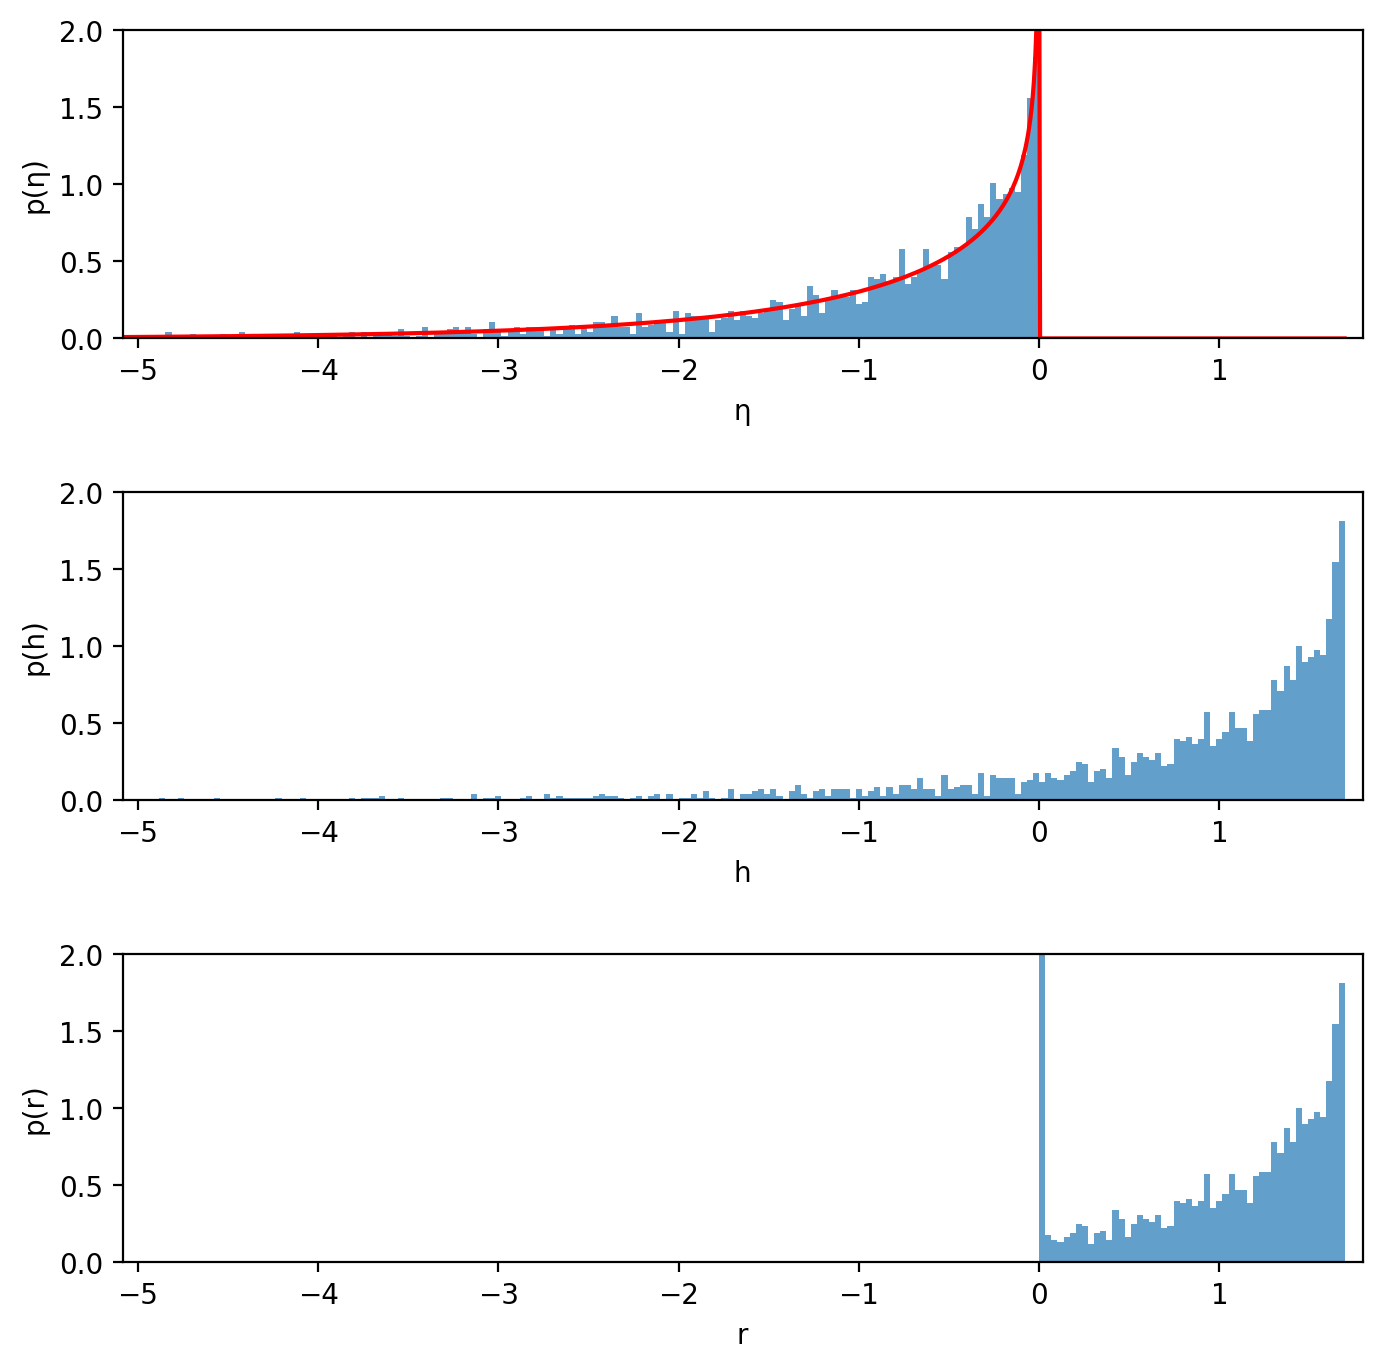

(0.0, 2.0)

In [9]:
let bins = [-3c1:c1/50:c1;]
    k(ψ,γ,m,C) = ψ^2*m^2/(γ^2*C)
    θ(ψ,γ,m,C) = γ^2*C/(ψ*m)
    kθ(ψ,γ,m,C) = (k(ψ,γ,m,C),θ(ψ,γ,m,C))
    xs = LinRange(bins[1],bins[end],1000)
    mxs = LinRange(-bins[end],-bins[1],1000)
    
    figure(figsize=(8,8),dpi=200)
    subplots_adjust(hspace=0.5)
    
    subplot(3,1,1)
    hist(η,bins,density=true,alpha=0.7)
    plot(-mxs,pdf.(Gamma(kθ(ψ1,γ1,m,C)...),mxs),"r")
    xlabel("η")
    ylabel("p(η)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(3,1,2)
    hist(h,bins,density=true,alpha=0.7)
    xlabel("h")
    ylabel("p(h)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(3,1,3)
    hist(r,bins,density=true,alpha=0.7)
    xlabel("r")
    ylabel("p(r)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
end

In [10]:
Nmeas = 10000

for n in eachindex(trials)
    pp = PopParams(1,α,-ψ1,γ1,c1,0.0,0.0,1.0)
    Wtemp,htemp,rtemp = rate(Nmeas,pp,[x1*sqrt(Σ1),sqrt(Σ1)],
        Nmeas,Tsim,Twrm,dts,seeds[trials[n]],1e-12)
    global h = htemp[end,:]
    global r = rtemp[end,:]
    global η = Wtemp*r
    
    @printf "#%d" trials[n]
    @printf "; α = %6.2f" α
    @printf "; r = %6.3f" mean(r)
    @printf "\n"
end

#1; α =   1.00; r =  0.963


In [11]:
μh = maximum(h)
u = mean(η)
Δ = var(η)
αh = u^2/Δ
θh = Δ/u
m = mean(r)
C = mean(r.^2)

@printf "μh = %6.3f, c = %6.3f\n" μh c1
@printf "αh = %6.3f, ψ²m²/γC = %6.3f\n" αh ψ1^2*m^2/(γ1^2*C)
@printf "θh = %6.3f, γ²C/ψm = %6.3f\n" θh -γ1^2*C/(ψ1*m)
@printf "⟨r⟩ = %6.3f\n" m
@printf "⟨(r-⟨r⟩)²⟩ = %6.3f\n" (C - m^2)
@printf "⟨(r-⟨r⟩)³⟩ = %6.3f\n" mean((r.-m).^3)

μh =  1.695, c =  1.695
αh =  0.704, ψ²m²/γC =  0.722
θh = -1.339, γ²C/ψm = -1.334
⟨r⟩ =  0.963
⟨(r-⟨r⟩)²⟩ =  0.357
⟨(r-⟨r⟩)³⟩ = -0.104


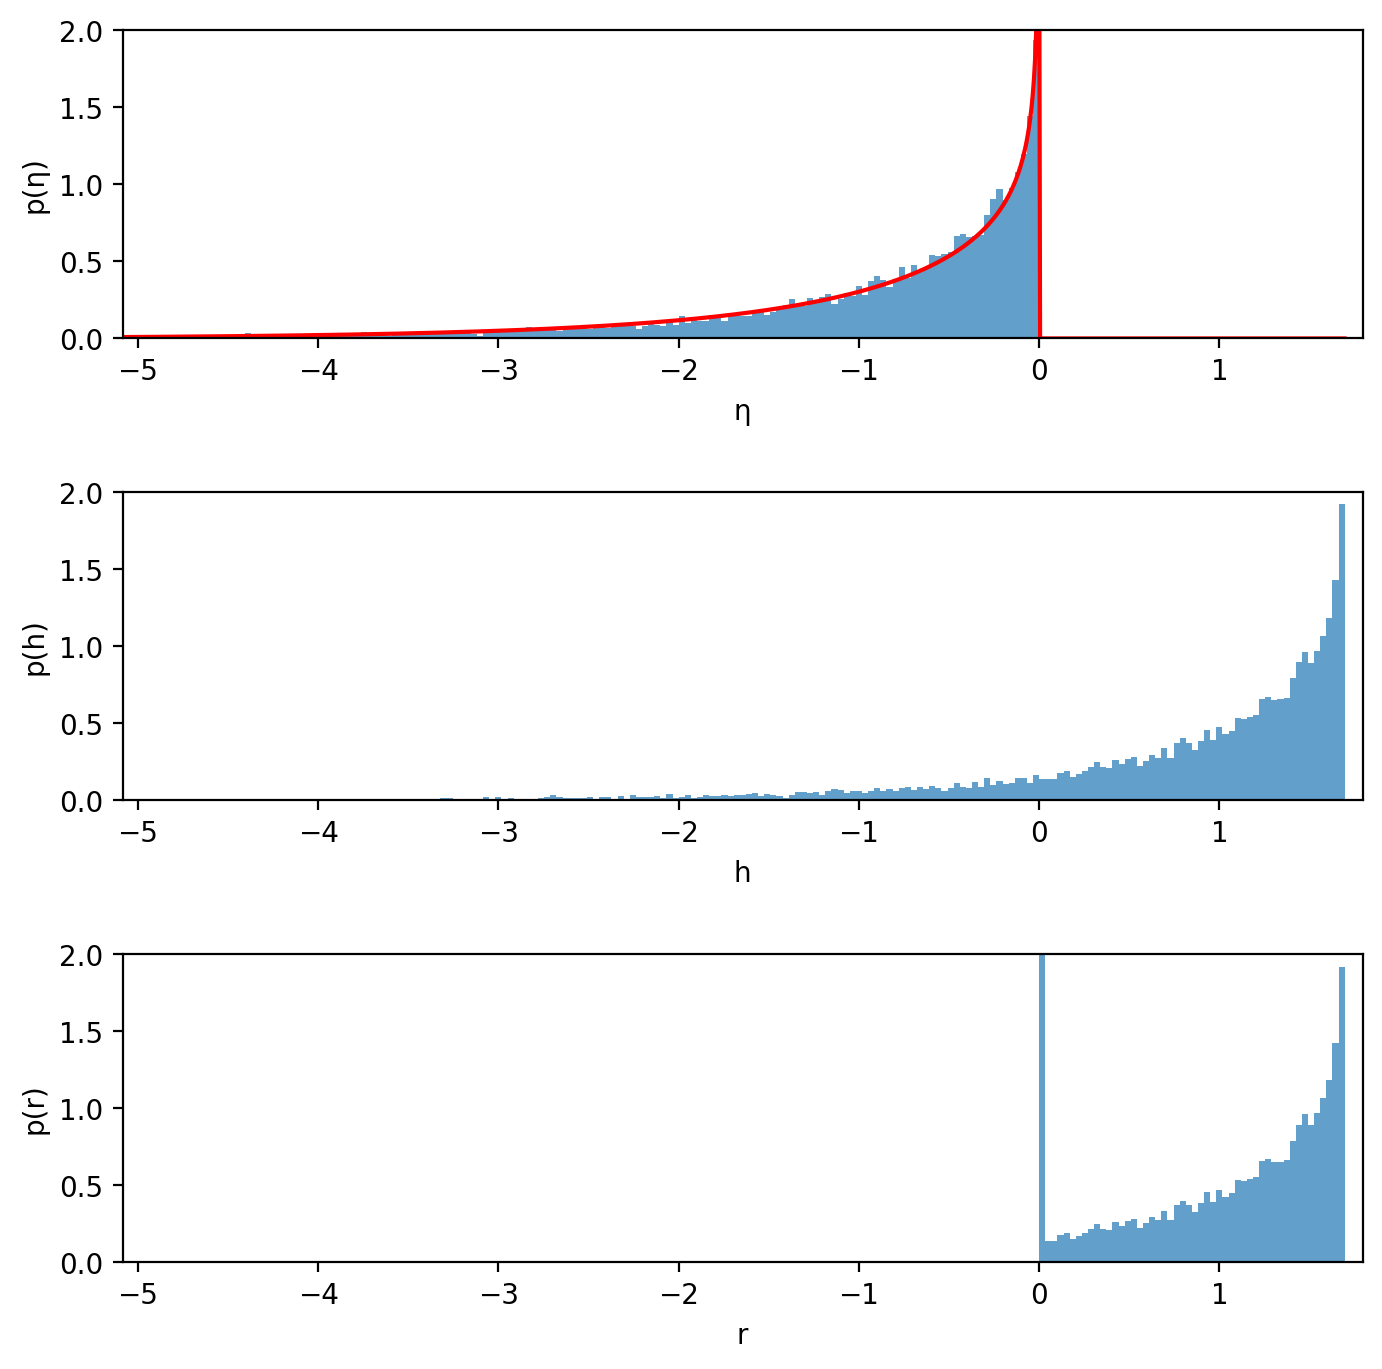

(0.0, 2.0)

In [12]:
let bins = [-3c1:c1/50:c1;]
    k(ψ,γ,m,C) = ψ^2*m^2/(γ^2*C)
    θ(ψ,γ,m,C) = γ^2*C/(ψ*m)
    kθ(ψ,γ,m,C) = (k(ψ,γ,m,C),θ(ψ,γ,m,C))
    xs = LinRange(bins[1],bins[end],1000)
    mxs = LinRange(-bins[end],-bins[1],1000)
    
    figure(figsize=(8,8),dpi=200)
    subplots_adjust(hspace=0.5)
    
    subplot(3,1,1)
    hist(η,bins,density=true,alpha=0.7)
    plot(-mxs,pdf.(Gamma(kθ(ψ1,γ1,m,C)...),mxs),"r")
    xlabel("η")
    ylabel("p(η)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(3,1,2)
    hist(h,bins,density=true,alpha=0.7)
    xlabel("h")
    ylabel("p(h)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(3,1,3)
    hist(r,bins,density=true,alpha=0.7)
    xlabel("r")
    ylabel("p(r)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
end

In [13]:
Nmeas = 10000

for n in eachindex(trials)
    pp = PopParams(2,α,-ψ2,γ2,c2,0.0,0.0,1.0)
    Wtemp,htemp,rtemp = rate(Nmeas,pp,[x2*sqrt(Σ2),sqrt(Σ2)],
        Nmeas,Tsim,Twrm,dts,seeds[trials[n]],1e-12)
    global h = htemp[end,:]
    global r = rtemp[end,:]
    global η = Wtemp*r
    
    @printf "#%d" trials[n]
    @printf "; α = %6.2f" α
    @printf "; r = %6.3f" mean(r)
    @printf "\n"
end

#1; α =   1.00; r =  0.967


In [14]:
μh = maximum(h)
u = mean(η)
Δ = var(η)
αh = u^2/Δ
θh = Δ/u
m = mean(r)
C = mean(r.^2)

@printf "μh = %6.3f, c = %6.3f\n" μh c2
@printf "αh = %6.3f, ψ²m²/γC = %6.3f\n" αh ψ2^2*m^2/(γ2^2*C)
@printf "θh = %6.3f, γ²C/ψm = %6.3f\n" θh -γ2^2*C/(ψ2*m)
@printf "⟨r⟩ = %6.3f\n" m
@printf "⟨(r-⟨r⟩)²⟩ = %6.3f\n" (C - m^2)
@printf "⟨(r-⟨r⟩)³⟩ = %6.3f\n" mean((r.-m).^3)

μh =  1.527, c =  1.536
αh =  2.650, ψ²m²/γC =  2.572
θh = -0.237, γ²C/ψm = -0.245
⟨r⟩ =  0.967
⟨(r-⟨r⟩)²⟩ =  0.323
⟨(r-⟨r⟩)³⟩ =  0.004


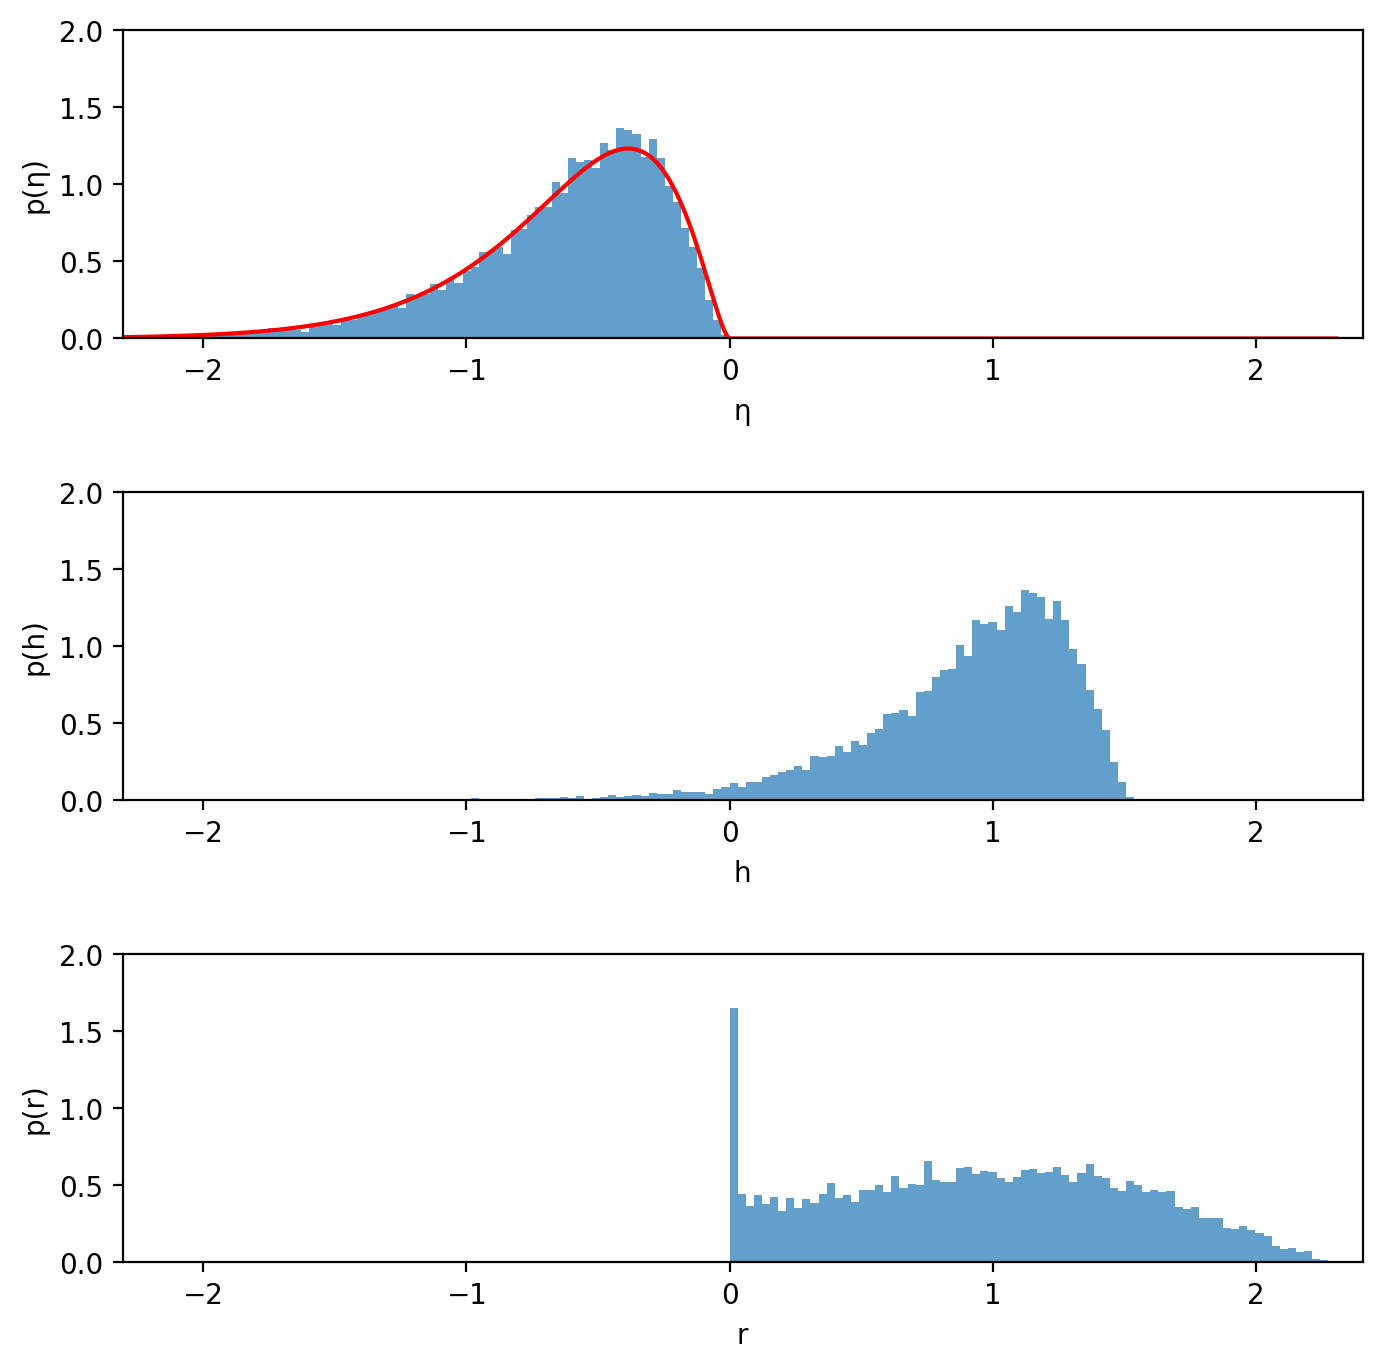

(0.0, 2.0)

In [15]:
let bins = [-1.5c2:c2/50:1.5c2;]
    k(ψ,γ,m,C) = ψ^2*m^2/(γ^2*C)
    θ(ψ,γ,m,C) = γ^2*C/(ψ*m)
    kθ(ψ,γ,m,C) = (k(ψ,γ,m,C),θ(ψ,γ,m,C))
    xs = LinRange(bins[1],bins[end],1000)
    mxs = LinRange(-bins[end],-bins[1],1000)
    
    figure(figsize=(8,8),dpi=200)
    subplots_adjust(hspace=0.5)
    
    subplot(3,1,1)
    hist(η,bins,density=true,alpha=0.7)
    plot(-mxs,pdf.(Gamma(kθ(ψ2,γ2,m,C)...),mxs),"r")
    xlabel("η")
    ylabel("p(η)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(3,1,2)
    hist(h,bins,density=true,alpha=0.7)
    xlabel("h")
    ylabel("p(h)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(3,1,3)
    hist(r,bins,density=true,alpha=0.7)
    xlabel("r")
    ylabel("p(r)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
end

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-07

Details:
    number of observations:   10000
    sample mean:              0.6285705059297203
    sample SD:                0.3861155661008713
    A² statistic:             203.71278561102554


One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           0.0026

Details:
    number of observations:   10000
    sample mean:              0.6285705059297203
    sample SD:                0.3861155661008713
    A² statistic:             5.098776349386444


One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           <1e-07

Details:
    number of observations:   10000
    sample mean:              0.6285705059297203
    sample SD:                0.3861155661008713
    A² statistic:             57.71091912521445


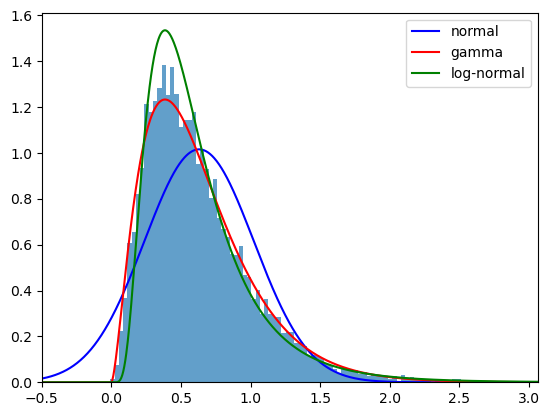

(-0.5, 3.0637055999999996)

In [63]:
let bins = [-0.5:c2/50:2.0c2;]
    u = ψ2*m
    Δ = γ2^2*C
#     u = mean(-η)
#     Δ = var(-η)
    
    xs = LinRange(bins[1],bins[end],1000)
    hist(-η,bins,density=true,alpha=0.7)
    
    dist = Normal(u,√(Δ))
    plot(xs,pdf.(dist,xs),"b",label="normal")
    display(OneSampleADTest(-η,dist))
    
    dist = Gamma(u^2/Δ,Δ/u)
    plot(xs,pdf.(dist,xs),"r",label="gamma")
    display(OneSampleADTest(-η,dist))
    
    dist = LogNormal(log(u^2/√(Δ+u^2)),√(log(Δ/u^2+1)))
    plot(xs,pdf.(dist,xs),"g",label="log-normal")
    display(OneSampleADTest(-η,dist))
    
    legend()
    
    xlim((bins[1],bins[end]))
end

# Two Population

In [19]:
struct MultiPopParams
    n::Int64                        # SSN power
    Npop::Int64
    α::Float64                      # SSN parameter
    γ̄::Matrix{Float64}              # mean connection parameter
    γ::Matrix{Float64}              # connection variance parameter
    ḡ::Vector{Float64}              # time-independent input
    δg::Vector{Float64}             # time-dependent input amplitude
    ω::Float64                      # time-dependent input frequency
    τ::Vector{Float64}              # time constant
    MultiPopParams(n::Int64,α::Float64,γ̄::Matrix{Float64},γ::Matrix{Float64},
        ḡ::Vector{Float64},δg::Vector{Float64},ω::Float64, τ::Vector{Float64}) = 
    begin
        if size(γ̄)[1] != size(γ̄)[2]
            error("γ̄ not a square matrix")
        elseif size(γ)[1] != size(γ)[2]
            error("γ not a square matrix")
        elseif size(γ̄)[1] != size(γ)[1]
            error("γ̄ and γ do not have the same size")
        elseif size(γ̄)[1] != length(ḡ)
            error("ḡ does not have the right size")
        elseif size(γ̄)[1] != length(δg)
            error("δg does not have the right size")
        elseif size(γ̄)[1] != length(τ)
            error("τ does not have the right size")
        end
        new(n,size(γ̄)[1],α,γ̄,γ,ḡ,δg,ω,τ)
    end
end

In [32]:
#################################################################################
## this script integrates rate networks                                        ##
## Rainer Engelken 2021                                                        ##
#################################################################################

# efficient implementation of chaotic rate network
function rate(N::Int64,pp::MultiPopParams,oup::OUParams,init::Matrix{Float64},
        Nmeas::Int64,Tsim,Twrm,dts,seed,tol)
    if size(init) != (pp.Npop,2)
        error("init does not have the right size")
    end
    Random.seed!(seed)              # seed random number generator
    function φ(h::Float64)::Float64 # rectified power law activation function
#         if h > 10maximum(pp.ḡ.+pp.δg)
#             error("Instability Detected")
#         end
        min(max(h,0)^pp.n,(5maximum(pp.ḡ.+pp.δg))^pp.n)
    end
    
    ####################################################################
    #### Gaussian connectivity weights #################################
    ####################################################################
    W = Array{Float64}(undef,(pp.Npop*N,pp.Npop*N))
    for i in 1:pp.Npop, j in 1:pp.Npop
        Wij = view(W,(i-1)*N+1:i*N,(j-1)*N+1:j*N)
        Wij .= rand(Gamma(pp.γ̄[i,j]^2/(pp.γ[i,j]^2*N),pp.γ[i,j]^2/abs(pp.γ̄[i,j])),(N,N))
        Wij .*= sign(pp.γ̄[i,j])     # generate initial network topology
#         Wij[diagind(Wij)] .= pp.γ̄[i,j]/N # remove variability in autapses
#         Wij[Wij .> 0] .= 0.0        # set all connections to be negative
    end
    
    h0 = Array{Float64}(undef,pp.Npop*N)
    τinv = Array{Float64}(undef,pp.Npop*N)
    ḡ = Array{Float64}(undef,pp.Npop*N)
    δg = Array{Float64}(undef,pp.Npop*N)
    for i in 1:pp.Npop
        h0[(i-1)*N+1:i*N] .= init[i,1].+init[i,2]*randn(N)
                                    # initialize network state
        τinv[(i-1)*N+1:i*N] .= 1/pp.τ[i]
                                    # calculate inverse time constant
        ḡ[(i-1)*N+1:i*N] .= pp.ḡ[i]
        δg[(i-1)*N+1:i*N] .= pp.δg[i]
    end
    tspan = (0.0,Tsim)              # define time span to simulate
    tsave = Twrm:dts:Tsim           # define times to save network state
    
    τinvW = τinv.*W
    
    ####################################################################
    #### optimized hyperparameters of Tsitouras 5/4 Runge-Kutta method #
    ####################################################################
    beta2 = 0.045
    rtol = 1e-8
    gamma = 0.95
    dt = 0.17
    maxi = 10^7
    
    r = Array{Float64}(undef,pp.Npop*N)
                                    # preallocate vector of firing rates
    idxs = Array{Int64}(undef,pp.Npop*Nmeas)
    for i in 1:pp.Npop
        idxs[(i-1)*Nmeas+1:i*Nmeas] .= [(i-1)*N+1:(i-1)*N+Nmeas;]
    end
                                    # indices of neurons to measure
    function f(dh,h,nothing,t)      # function with equation of motion passed to 
                                    # DifferentialEquations
        g = ḡ.+δg*sin(pp.ω*t)       # calculate input at this time
        dh .= g.-h                  # use dh vector initially to store g-h
        @fastmath map!(φ,r,h)       # calculate firing rates
        @fastmath BLAS.gemv!('N',1.0,W,r,1.0,dh)
                                    # calculate increment of local fields
                                    # in place using BLAS
        dh .*= τinv                 # divide increment by τ
    end
    prob = ODEProblem(f,h0,tspan)
                                    # initialize ODE Problem for DifferentialEquations
    sol = solve(prob,Tsit5(),reltol=rtol,abstol=tol,beta2=beta2,gamma=gamma,dt=dt,
        save_idxs=idxs,save_everystep=false,saveat=tsave,
        maxiters=maxi)              # solve ODE using Tsitouras 5/4 Runge-Kutta method
    h = reduce(hcat,sol.u)'         # extract local fields from solution
    rAll = map(φ,h)  # get firing rates
    return (W,h,rAll)
end

rate (generic function with 2 methods)

In [21]:
Ntrial = 10

Tsim = 800.0
Twrm = 600.0
dts = 0.02
ts = collect(Twrm:dts:Tsim)

seeds = trunc.(Int,rand(MersenneTwister(1234),Ntrial)*2^31)

α = 1.0

ψ1 = 1.0
γ1 = 1.0
c1 = 1.69453
x1 = 0.470655
Σ1 = 2.1776

ψ2 = 0.651009
γ2 = 0.35
c2 = 1.53608
x2 = 1.89401
Σ2 = 0.218367

J = [0.4 -1.5; 0.5 -1.5]

2×2 Matrix{Float64}:
 0.4  -1.5
 0.5  -1.5

In [22]:
trials = [1]

1-element Vector{Int64}:
 1

In [26]:
Nmeas = 2000

for n in eachindex(trials)
    pp = MultiPopParams(1,α,ψ1*J,γ1/sqrt(2)*ones((2,2)),c1*ones(2),zeros(2),0.0,ones(2))
    Wtemp,htemp,rtemp = rate(Nmeas,pp,[0.8x1*sqrt(Σ1) sqrt(Σ1); x1*sqrt(Σ1) sqrt(Σ1)],
        Nmeas,Tsim,Twrm,dts,seeds[trials[n]],1e-12)
    global hE = htemp[end,1:Nmeas]
    global hI = htemp[end,Nmeas+1:end]
    global rE = rtemp[end,1:Nmeas]
    global rI = rtemp[end,Nmeas+1:end]
    global ηEE = Wtemp[1:Nmeas,1:Nmeas]*rE
    global ηEI = Wtemp[1:Nmeas,Nmeas+1:end]*rI
    global ηIE = Wtemp[Nmeas+1:end,1:Nmeas]*rE
    global ηII = Wtemp[Nmeas+1:end,Nmeas+1:end]*rI
    
    @printf "#%d" trials[n]
    @printf "; α = %6.2f" α
    @printf "; rE = %6.3f" mean(rE)
    @printf "; rI = %6.3f" mean(rI)
    @printf "\n"
end

#1; α =   1.00; rE =  0.856; rI =  0.938


In [27]:
mE = mean(rE)
CE = mean(rE.^2)

mI = mean(rI)
CI = mean(rI.^2)

uEE = mean(ηEE)
ΔEE = var(ηEE)
αEE = uEE^2/ΔEE
θEE = ΔEE/uEE

uEI = mean(ηEI)
ΔEI = var(ηEI)
αEI = uEI^2/ΔEI
θEI = ΔEI/uEI

uIE = mean(ηIE)
ΔIE = var(ηIE)
αIE = uIE^2/ΔIE
θIE = ΔIE/uIE

uII = mean(ηII)
ΔII = var(ηII)
αII = uII^2/ΔII
θII = ΔII/uII

@printf "αEE = %6.3f, ψ²m²/γC = %6.3f\n" αEE (J[1,1]*ψ1)^2*mE^2/(γ1^2/2*CE)
@printf "θEE = %6.3f, γ²C/ψm = %6.3f\n" θEE γ1^2/2*CE/((J[1,1]*ψ1)*mE)
@printf "αEI = %6.3f, ψ²m²/γC = %6.3f\n" αEI (J[1,2]*ψ1)^2*mI^2/(γ1^2/2*CI)
@printf "θEI = %6.3f, γ²C/ψm = %6.3f\n" θEI γ1^2/2*CI/((J[1,2]*ψ1)*mI)
@printf "αIE = %6.3f, ψ²m²/γC = %6.3f\n" αIE (J[2,1]*ψ1)^2*mE^2/(γ1^2/2*CE)
@printf "θIE = %6.3f, γ²C/ψm = %6.3f\n" θIE γ1^2/2*CE/((J[2,1]*ψ1)*mE)
@printf "αII = %6.3f, ψ²m²/γC = %6.3f\n" αII (J[2,2]*ψ1)^2*mI^2/(γ1^2/2*CI)
@printf "θII = %6.3f, γ²C/ψm = %6.3f\n" θII γ1^2/2*CI/((J[2,2]*ψ1)*mI)
@printf "⟨rE⟩ = %6.3f\n" mE
@printf "⟨(rE-⟨rE⟩)²⟩ = %6.3f\n" (CE - mE^2)
@printf "⟨(rE-⟨rE⟩)³⟩ = %6.3f\n" mean((rE.-mE).^3)
@printf "⟨rI⟩ = %6.3f\n" mI
@printf "⟨(rI-⟨rI⟩)²⟩ = %6.3f\n" (CI - mI^2)
@printf "⟨(rI-⟨rI⟩)³⟩ = %6.3f\n" mean((rI.-mI).^3)

αEE =  0.163, ψ²m²/γC =  0.141
θEE =  2.289, γ²C/ψm =  2.431
αEI =  1.897, ψ²m²/γC =  2.046
θEI = -0.750, γ²C/ψm = -0.688
αIE =  0.214, ψ²m²/γC =  0.220
θIE =  2.138, γ²C/ψm =  1.945
αII =  1.976, ψ²m²/γC =  2.046
θII = -0.707, γ²C/ψm = -0.688
⟨rE⟩ =  0.856
⟨(rE-⟨rE⟩)²⟩ =  0.932
⟨(rE-⟨rE⟩)³⟩ =  2.591
⟨rI⟩ =  0.938
⟨(rI-⟨rI⟩)²⟩ =  1.056
⟨(rI-⟨rI⟩)³⟩ =  3.197


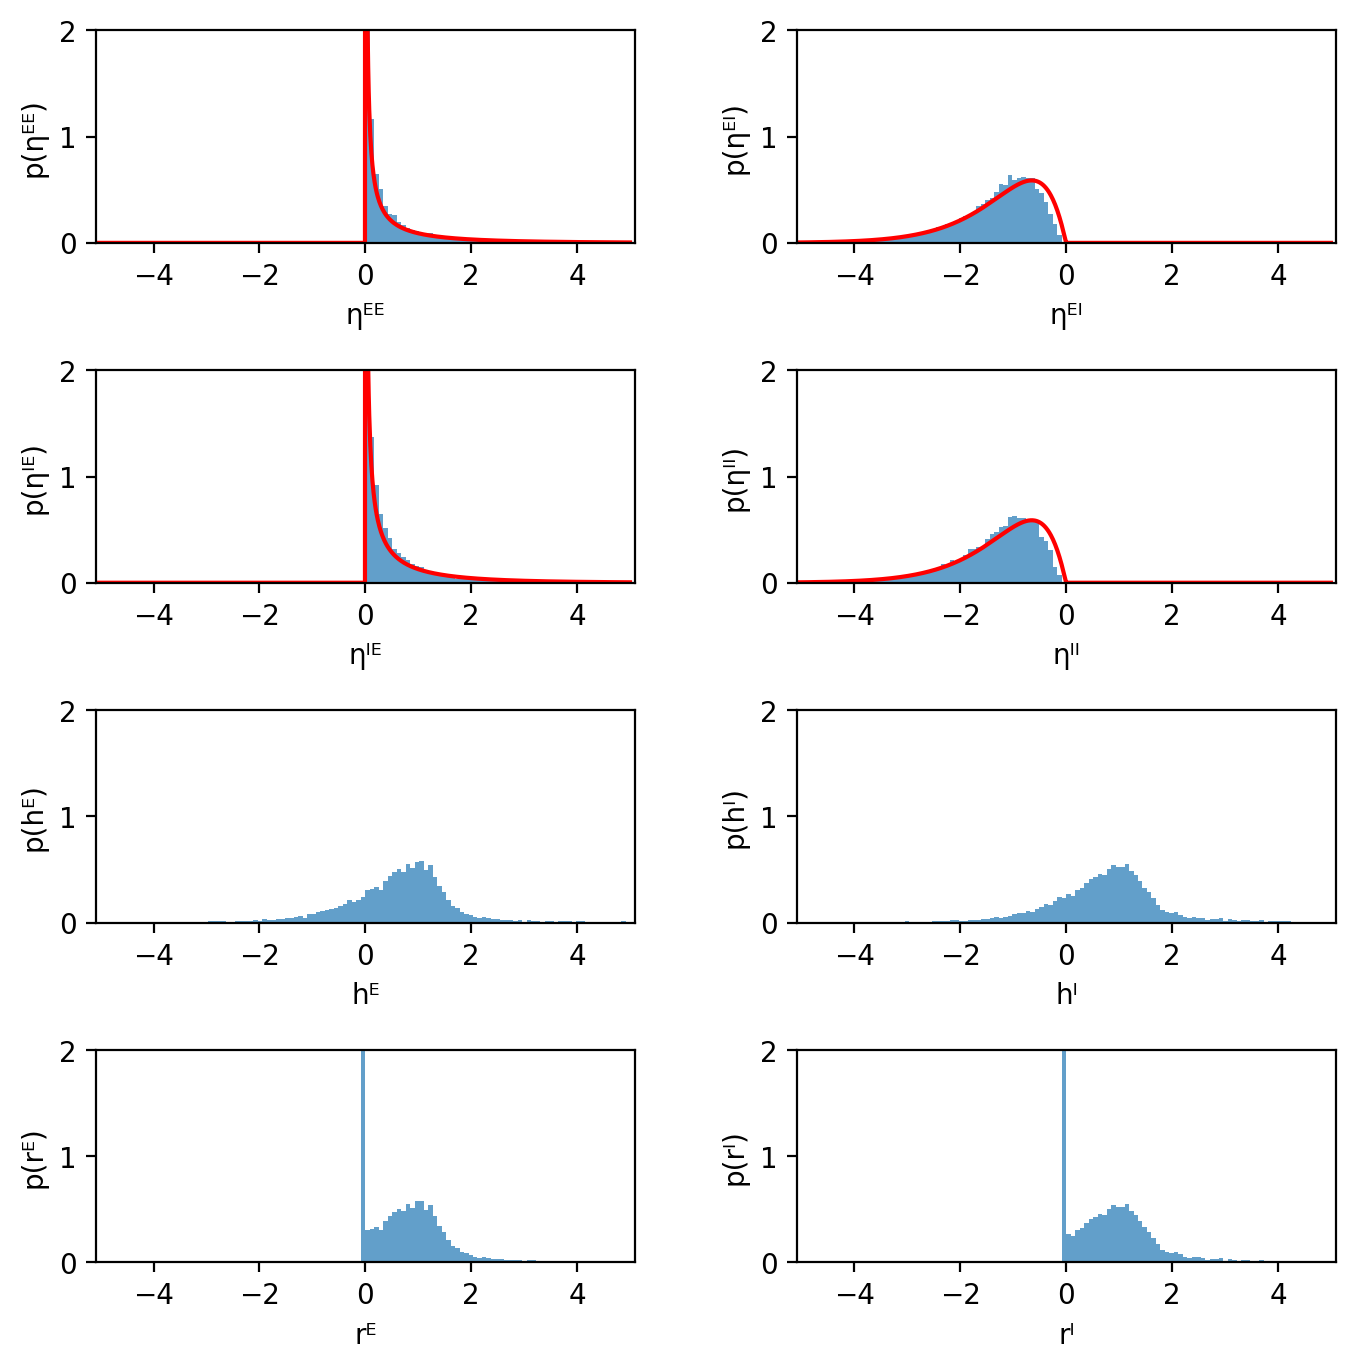

(0.0, 2.0)

In [37]:
let bins = [-3c1:c1/20:3c1;]
    k(ψ,γ,m,C) = ψ^2*m^2/(γ^2*C)
    θ(ψ,γ,m,C) = γ^2*C/(ψ*m)
    kθ(ψ,γ,m,C) = (k(ψ,γ,m,C),θ(ψ,γ,m,C))
    xs = LinRange(bins[1],bins[end],1000)
    mxs = LinRange(-bins[end],-bins[1],1000)
    
    figure(figsize=(8,8),dpi=200)
    subplots_adjust(hspace=0.6,wspace=0.3)
    
    subplot(4,2,1)
    hist(ηEE,bins,density=true,alpha=0.7)
    plot(xs,pdf.(Gamma(kθ(ψ1*J[1,1],γ1/sqrt(2),mE,CE)...),xs),"r")
    xlabel("ηᴱᴱ")
    ylabel("p(ηᴱᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,2)
    hist(ηEI,bins,density=true,alpha=0.7)
    plot(-mxs,pdf.(Gamma(kθ(-ψ1*J[1,2],γ1/sqrt(2),mI,CI)...),mxs),"r")
    xlabel("ηᴱᴵ")
    ylabel("p(ηᴱᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,3)
    hist(ηIE,bins,density=true,alpha=0.7)
    plot(xs,pdf.(Gamma(kθ(ψ1*J[2,1],γ1/sqrt(2),mE,CE)...),xs),"r")
    xlabel("ηᴵᴱ")
    ylabel("p(ηᴵᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,4)
    hist(ηII,bins,density=true,alpha=0.7)
    plot(-mxs,pdf.(Gamma(kθ(-ψ1*J[2,2],γ1/sqrt(2),mI,CI)...),mxs),"r")
    xlabel("ηᴵᴵ")
    ylabel("p(ηᴵᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,5)
    hist(hE,bins,density=true,alpha=0.7)
    xlabel("hᴱ")
    ylabel("p(hᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,6)
    hist(hI,bins,density=true,alpha=0.7)
    xlabel("hᴵ")
    ylabel("p(hᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,7)
    hist(rE,bins,density=true,alpha=0.7)
    xlabel("rᴱ")
    ylabel("p(rᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,8)
    hist(rI,bins,density=true,alpha=0.7)
    xlabel("rᴵ")
    ylabel("p(rᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
end

In [48]:
Nmeas = 10000

trials = [1]
for n in eachindex(trials)
    pp = MultiPopParams(1,α,ψ1*J,γ1/sqrt(2)*ones((2,2)),c1*ones(2),zeros(2),0.0,ones(2))
    Wtemp,htemp,rtemp = rate(Nmeas,pp,[0.8x1*sqrt(Σ1) sqrt(Σ1); x1*sqrt(Σ1) sqrt(Σ1)],
        Nmeas,Tsim,Twrm,dts,seeds[trials[n]],1e-12)
    global hE = htemp[end,1:Nmeas]
    global hI = htemp[end,Nmeas+1:end]
    global rE = rtemp[end,1:Nmeas]
    global rI = rtemp[end,Nmeas+1:end]
    global ηEE = Wtemp[1:Nmeas,1:Nmeas]*rE
    global ηEI = Wtemp[1:Nmeas,Nmeas+1:end]*rI
    global ηIE = Wtemp[Nmeas+1:end,1:Nmeas]*rE
    global ηII = Wtemp[Nmeas+1:end,Nmeas+1:end]*rI
    
    @printf "#%d" trials[n]
    @printf "; α = %6.2f" α
    @printf "; rE = %6.3f" mean(rE)
    @printf "; rI = %6.3f" mean(rI)
    @printf "\n"
end

#1; α =   1.00; rE =  0.839; rI =  0.913


In [49]:
mE = mean(rE)
CE = mean(rE.^2)

mI = mean(rI)
CI = mean(rI.^2)

uEE = mean(ηEE)
ΔEE = var(ηEE)
αEE = uEE^2/ΔEE
θEE = ΔEE/uEE

uEI = mean(ηEI)
ΔEI = var(ηEI)
αEI = uEI^2/ΔEI
θEI = ΔEI/uEI

uIE = mean(ηIE)
ΔIE = var(ηIE)
αIE = uIE^2/ΔIE
θIE = ΔIE/uIE

uII = mean(ηII)
ΔII = var(ηII)
αII = uII^2/ΔII
θII = ΔII/uII

@printf "αEE = %6.3f, ψ²m²/γC = %6.3f\n" αEE (J[1,1]*ψ1)^2*mE^2/(γ1^2/2*CE)
@printf "θEE = %6.3f, γ²C/ψm = %6.3f\n" θEE γ1^2/2*CE/((J[1,1]*ψ1)*mE)
@printf "αEI = %6.3f, ψ²m²/γC = %6.3f\n" αEI (J[1,2]*ψ1)^2*mI^2/(γ1^2/2*CI)
@printf "θEI = %6.3f, γ²C/ψm = %6.3f\n" θEI γ1^2/2*CI/((J[1,2]*ψ1)*mI)
@printf "αIE = %6.3f, ψ²m²/γC = %6.3f\n" αIE (J[2,1]*ψ1)^2*mE^2/(γ1^2/2*CE)
@printf "θIE = %6.3f, γ²C/ψm = %6.3f\n" θIE γ1^2/2*CE/((J[2,1]*ψ1)*mE)
@printf "αII = %6.3f, ψ²m²/γC = %6.3f\n" αII (J[2,2]*ψ1)^2*mI^2/(γ1^2/2*CI)
@printf "θII = %6.3f, γ²C/ψm = %6.3f\n" θII γ1^2/2*CI/((J[2,2]*ψ1)*mI)
@printf "⟨rE⟩ = %6.3f\n" mE
@printf "⟨(rE-⟨rE⟩)²⟩ = %6.3f\n" (CE - mE^2)
@printf "⟨(rE-⟨rE⟩)³⟩ = %6.3f\n" mean((rE.-mE).^3)
@printf "⟨rI⟩ = %6.3f\n" mI
@printf "⟨(rI-⟨rI⟩)²⟩ = %6.3f\n" (CI - mI^2)
@printf "⟨(rI-⟨rI⟩)³⟩ = %6.3f\n" mean((rI.-mI).^3)

αEE =  0.169, ψ²m²/γC =  0.147
θEE =  1.973, γ²C/ψm =  2.276
αEI =  2.282, ψ²m²/γC =  2.212
θEI = -0.598, γ²C/ψm = -0.619
αIE =  0.261, ψ²m²/γC =  0.230
θIE =  1.616, γ²C/ψm =  1.821
αII =  2.218, ψ²m²/γC =  2.212
θII = -0.618, γ²C/ψm = -0.619
⟨rE⟩ =  0.839
⟨(rE-⟨rE⟩)²⟩ =  0.824
⟨(rE-⟨rE⟩)³⟩ =  2.157
⟨rI⟩ =  0.913
⟨(rI-⟨rI⟩)²⟩ =  0.861
⟨(rI-⟨rI⟩)³⟩ =  1.959


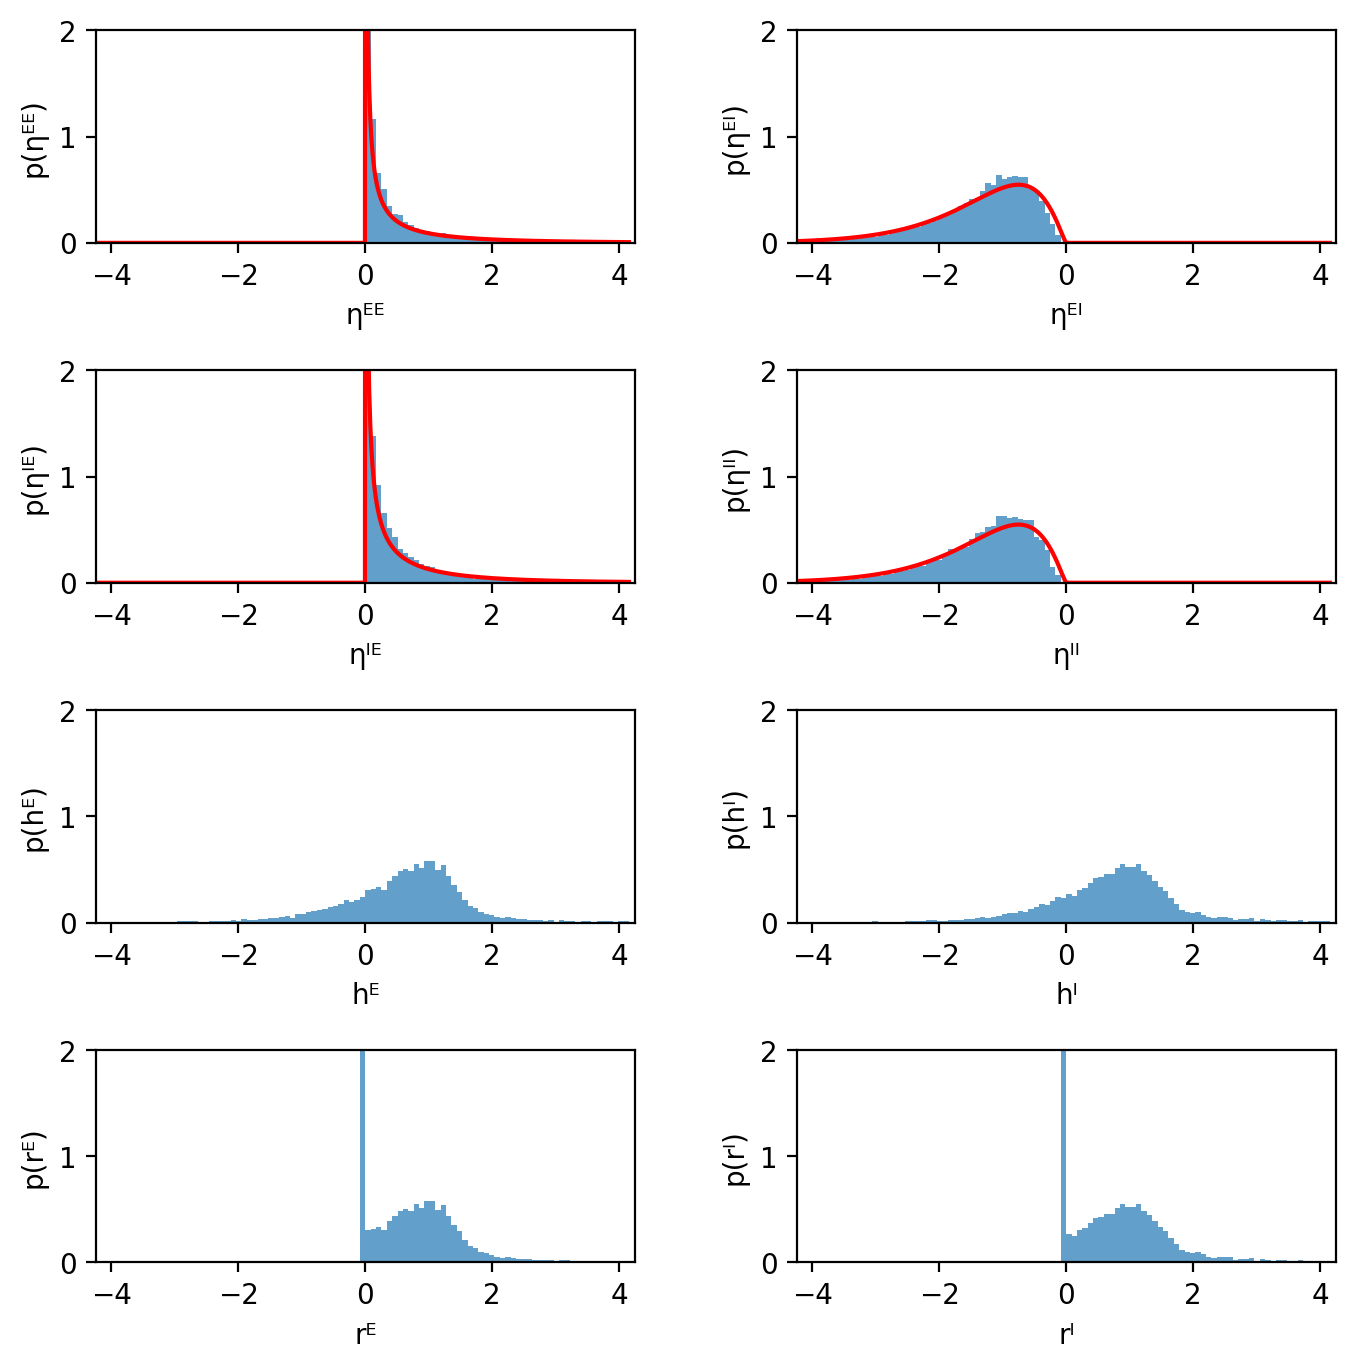

(0.0, 2.0)

In [50]:
let bins = [-2.5c1:c1/20:2.5c1;]
    k(ψ,γ,m,C) = ψ^2*m^2/(γ^2*C)
    θ(ψ,γ,m,C) = γ^2*C/(ψ*m)
    kθ(ψ,γ,m,C) = (k(ψ,γ,m,C),θ(ψ,γ,m,C))
    xs = LinRange(bins[1],bins[end],1000)
    mxs = LinRange(-bins[end],-bins[1],1000)
    
    figure(figsize=(8,8),dpi=200)
    subplots_adjust(hspace=0.6,wspace=0.3)
    
    subplot(4,2,1)
    hist(ηEE,bins,density=true,alpha=0.7)
    plot(xs,pdf.(Gamma(kθ(ψ1*J[1,1],γ1/sqrt(2),mE,CE)...),xs),"r")
    xlabel("ηᴱᴱ")
    ylabel("p(ηᴱᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,2)
    hist(ηEI,bins,density=true,alpha=0.7)
    plot(-mxs,pdf.(Gamma(kθ(-ψ1*J[1,2],γ1/sqrt(2),mI,CI)...),mxs),"r")
    xlabel("ηᴱᴵ")
    ylabel("p(ηᴱᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,3)
    hist(ηIE,bins,density=true,alpha=0.7)
    plot(xs,pdf.(Gamma(kθ(ψ1*J[2,1],γ1/sqrt(2),mE,CE)...),xs),"r")
    xlabel("ηᴵᴱ")
    ylabel("p(ηᴵᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,4)
    hist(ηII,bins,density=true,alpha=0.7)
    plot(-mxs,pdf.(Gamma(kθ(-ψ1*J[2,2],γ1/sqrt(2),mI,CI)...),mxs),"r")
    xlabel("ηᴵᴵ")
    ylabel("p(ηᴵᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,5)
    hist(hE,bins,density=true,alpha=0.7)
    xlabel("hᴱ")
    ylabel("p(hᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,6)
    hist(hI,bins,density=true,alpha=0.7)
    xlabel("hᴵ")
    ylabel("p(hᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,7)
    hist(rE,bins,density=true,alpha=0.7)
    xlabel("rᴱ")
    ylabel("p(rᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,8)
    hist(rI,bins,density=true,alpha=0.7)
    xlabel("rᴵ")
    ylabel("p(rᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
end

In [38]:
Nmeas = 10000

trials = [1]
for n in eachindex(trials)
    pp = MultiPopParams(2,α,ψ2*J,γ2/sqrt(2)*ones((2,2)),c2*ones(2),zeros(2),0.0,ones(2))
    Wtemp,htemp,rtemp = rate(Nmeas,pp,[0.8x2*sqrt(Σ2) sqrt(Σ2); x2*sqrt(Σ2) sqrt(Σ2)],
        Nmeas,Tsim,Twrm,dts,seeds[trials[n]],1e-12)
    global hE = htemp[end,1:Nmeas]
    global hI = htemp[end,Nmeas+1:end]
    global rE = rtemp[end,1:Nmeas]
    global rI = rtemp[end,Nmeas+1:end]
    global ηEE = Wtemp[1:Nmeas,1:Nmeas]*rE
    global ηEI = Wtemp[1:Nmeas,Nmeas+1:end]*rI
    global ηIE = Wtemp[Nmeas+1:end,1:Nmeas]*rE
    global ηII = Wtemp[Nmeas+1:end,Nmeas+1:end]*rI
    
    @printf "#%d" trials[n]
    @printf "; α = %6.2f" α
    @printf "; rE = %6.3f" mean(rE)
    @printf "; rI = %6.3f" mean(rI)
    @printf "\n"
end

#1; α =   1.00; rE =  0.889; rI =  1.007


In [39]:
mE = mean(rE)
CE = mean(rE.^2)

mI = mean(rI)
CI = mean(rI.^2)

uEE = mean(ηEE)
ΔEE = var(ηEE)
αEE = uEE^2/ΔEE
θEE = ΔEE/uEE

uEI = mean(ηEI)
ΔEI = var(ηEI)
αEI = uEI^2/ΔEI
θEI = ΔEI/uEI

uIE = mean(ηIE)
ΔIE = var(ηIE)
αIE = uIE^2/ΔIE
θIE = ΔIE/uIE

uII = mean(ηII)
ΔII = var(ηII)
αII = uII^2/ΔII
θII = ΔII/uII

@printf "αEE = %6.3f, ψ²m²/γC = %6.3f\n" αEE (J[1,1]*ψ2)^2*mE^2/(γ2^2/2*CE)
@printf "θEE = %6.3f, γ²C/ψm = %6.3f\n" θEE γ2^2/2*CE/((J[1,1]*ψ2)*mE)
@printf "αEI = %6.3f, ψ²m²/γC = %6.3f\n" αEI (J[1,2]*ψ2)^2*mI^2/(γ2^2/2*CI)
@printf "θEI = %6.3f, γ²C/ψm = %6.3f\n" θEI γ2^2/2*CI/((J[1,2]*ψ2)*mI)
@printf "αIE = %6.3f, ψ²m²/γC = %6.3f\n" αIE (J[2,1]*ψ2)^2*mE^2/(γ2^2/2*CE)
@printf "θIE = %6.3f, γ²C/ψm = %6.3f\n" θIE γ2^2/2*CE/((J[2,1]*ψ2)*mE)
@printf "αII = %6.3f, ψ²m²/γC = %6.3f\n" αII (J[2,2]*ψ2)^2*mI^2/(γ2^2/2*CI)
@printf "θII = %6.3f, γ²C/ψm = %6.3f\n" θII γ2^2/2*CI/((J[2,2]*ψ2)*mI)
@printf "⟨rE⟩ = %6.3f\n" mE
@printf "⟨(rE-⟨rE⟩)²⟩ = %6.3f\n" (CE - mE^2)
@printf "⟨(rE-⟨rE⟩)³⟩ = %6.3f\n" mean((rE.-mE).^3)
@printf "⟨rI⟩ = %6.3f\n" mI
@printf "⟨(rI-⟨rI⟩)²⟩ = %6.3f\n" (CI - mI^2)
@printf "⟨(rI-⟨rI⟩)³⟩ = %6.3f\n" mean((rI.-mI).^3)

αEE =  0.309, ψ²m²/γC =  0.259
θEE =  0.739, γ²C/ψm =  0.894
αEI =  3.611, ψ²m²/γC =  3.839
θEI = -0.274, γ²C/ψm = -0.256
αIE =  0.608, ψ²m²/γC =  0.405
θIE =  0.474, γ²C/ψm =  0.715
αII =  4.338, ψ²m²/γC =  3.839
θII = -0.226, γ²C/ψm = -0.256
⟨rE⟩ =  0.889
⟨(rE-⟨rE⟩)²⟩ =  2.587
⟨(rE-⟨rE⟩)³⟩ = 81.921
⟨rI⟩ =  1.007
⟨(rI-⟨rI⟩)²⟩ =  3.100
⟨(rI-⟨rI⟩)³⟩ = 86.244


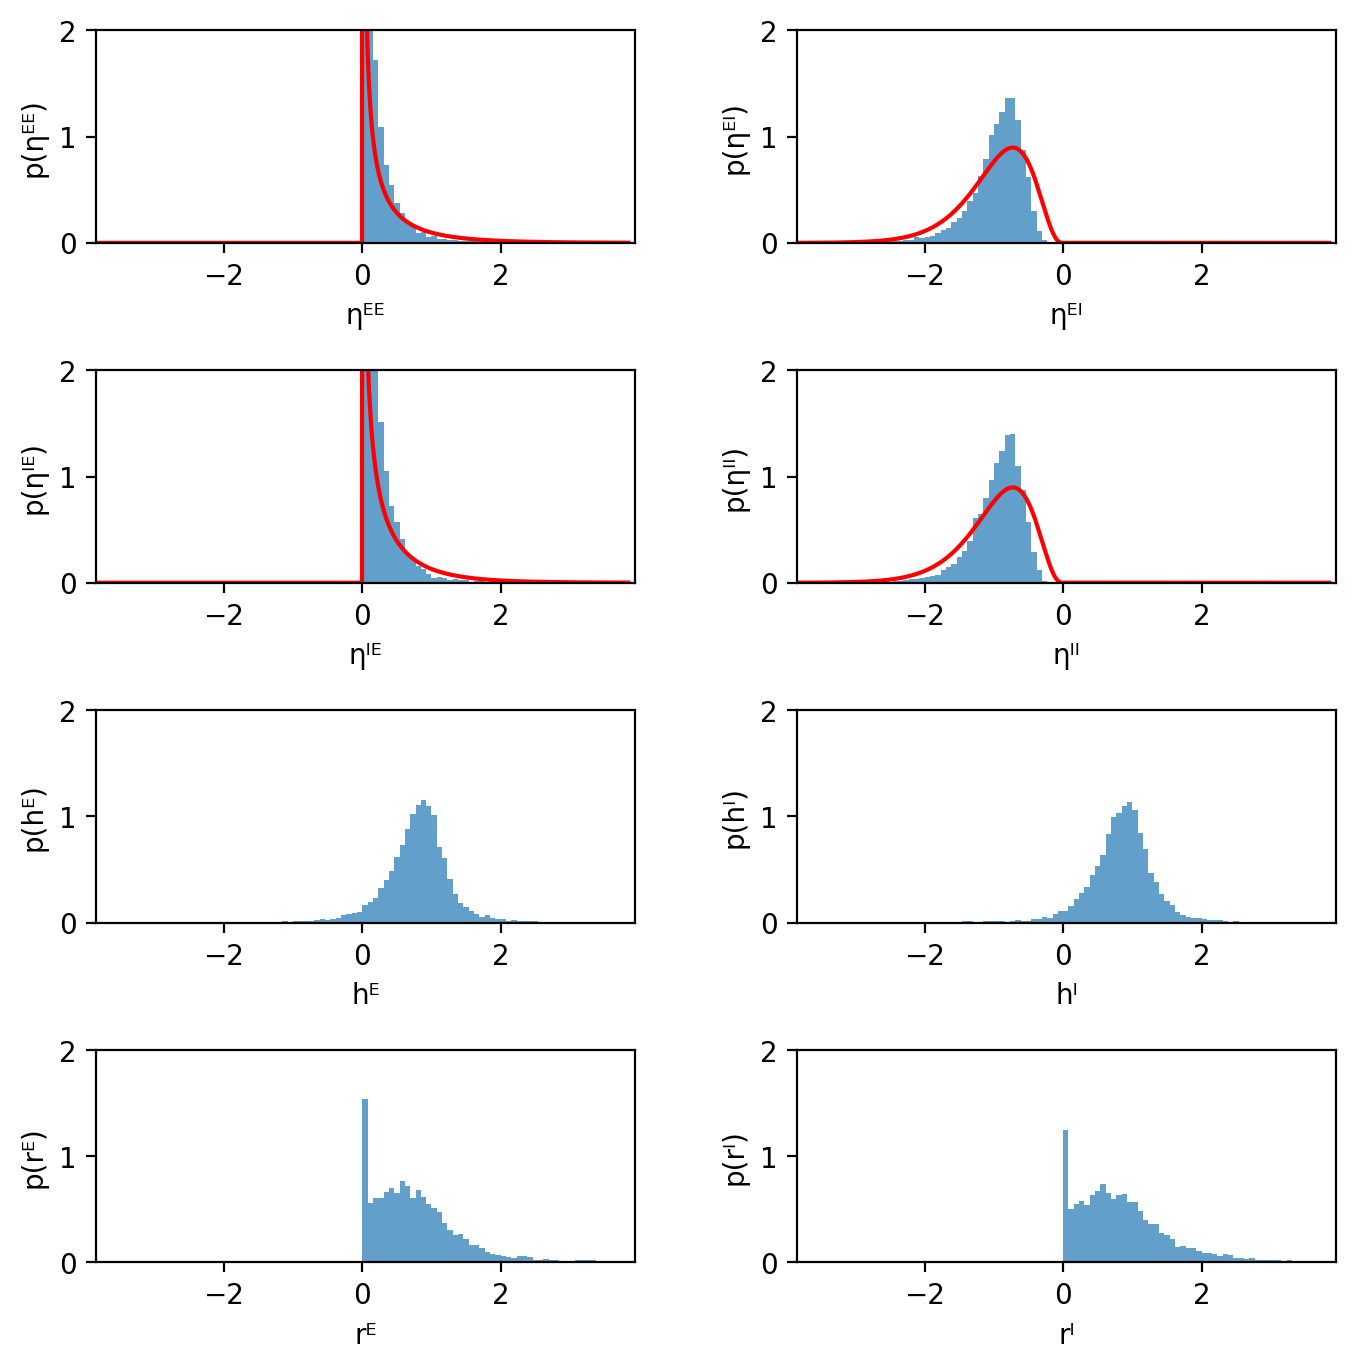

(0.0, 2.0)

In [47]:
let bins = [-2.5c2:c2/20:2.5c2;]
    k(ψ,γ,m,C) = ψ^2*m^2/(γ^2*C)
    θ(ψ,γ,m,C) = γ^2*C/(ψ*m)
    kθ(ψ,γ,m,C) = (k(ψ,γ,m,C),θ(ψ,γ,m,C))
    xs = LinRange(bins[1],bins[end],1000)
    mxs = LinRange(-bins[end],-bins[1],1000)
    
    figure(figsize=(8,8),dpi=200)
    subplots_adjust(hspace=0.6,wspace=0.3)
    
    subplot(4,2,1)
    hist(ηEE,bins,density=true,alpha=0.7)
    plot(xs,pdf.(Gamma(kθ(ψ2*J[1,1],γ2/sqrt(2),mE,CE)...),xs),"r")
    xlabel("ηᴱᴱ")
    ylabel("p(ηᴱᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,2)
    hist(ηEI,bins,density=true,alpha=0.7)
    plot(-mxs,pdf.(Gamma(kθ(-ψ2*J[1,2],γ2/sqrt(2),mI,CI)...),mxs),"r")
    xlabel("ηᴱᴵ")
    ylabel("p(ηᴱᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,3)
    hist(ηIE,bins,density=true,alpha=0.7)
    plot(xs,pdf.(Gamma(kθ(ψ2*J[2,1],γ2/sqrt(2),mE,CE)...),xs),"r")
    xlabel("ηᴵᴱ")
    ylabel("p(ηᴵᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,4)
    hist(ηII,bins,density=true,alpha=0.7)
    plot(-mxs,pdf.(Gamma(kθ(-ψ2*J[2,2],γ2/sqrt(2),mI,CI)...),mxs),"r")
    xlabel("ηᴵᴵ")
    ylabel("p(ηᴵᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,5)
    hist(hE,bins,density=true,alpha=0.7)
    xlabel("hᴱ")
    ylabel("p(hᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,6)
    hist(hI,bins,density=true,alpha=0.7)
    xlabel("hᴵ")
    ylabel("p(hᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,7)
    hist(rE,bins,density=true,alpha=0.7)
    xlabel("rᴱ")
    ylabel("p(rᴱ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
    
    subplot(4,2,8)
    hist(rI,bins,density=true,alpha=0.7)
    xlabel("rᴵ")
    ylabel("p(rᴵ)")
    xlim((bins[1],bins[end]+0.1))
    ylim((0,2))
end